<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle
import os

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2023-09-21 20:13:03--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2023-09-21 20:13:03--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2023-09-21 20:13:04--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (

In [3]:
# # Armar el dataset utilizando salto de línea para separar las oraciones/docs
# df = pd.read_csv('./songs_dataset/beatles.txt', sep='/n', header=None)
# df.head()

In [4]:
os.listdir("./songs_dataset/")

['lady-gaga.txt',
 'leonard-cohen.txt',
 'janisjoplin.txt',
 'drake.txt',
 'disney.txt',
 'missy-elliott.txt',
 'adele.txt',
 'jimi-hendrix.txt',
 'notorious-big.txt',
 'beatles.txt',
 'lorde.txt',
 'britney-spears.txt',
 'bob-marley.txt',
 'eminem.txt',
 'joni-mitchell.txt',
 'bruce-springsteen.txt',
 'radiohead.txt',
 'nirvana.txt',
 'al-green.txt',
 'dolly-parton.txt',
 'nicki-minaj.txt',
 'bieber.txt',
 'rihanna.txt',
 'dickinson.txt',
 'amy-winehouse.txt',
 'johnny-cash.txt',
 'lin-manuel-miranda.txt',
 'kanye-west.txt',
 'r-kelly.txt',
 'Kanye_West.txt',
 'dj-khaled.txt',
 'alicia-keys.txt',
 'kanye.txt',
 'dr-seuss.txt',
 'bjork.txt',
 'bob-dylan.txt',
 'Lil_Wayne.txt',
 'lil-wayne.txt',
 'nursery_rhymes.txt',
 'bruno-mars.txt',
 'patti-smith.txt',
 'nickelback.txt',
 'blink-182.txt',
 'prince.txt',
 'michael-jackson.txt',
 'ludacris.txt',
 'cake.txt',
 'notorious_big.txt',
 'paul-simon.txt']

In [5]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
# text_files = os.listdir("./songs_dataset/")
text_files = ['al-green.txt']
df = pd.DataFrame()
for text in text_files:
    path = "./songs_dataset/" + text
    df_i = pd.read_csv(path, sep='/n', header=None, engine='python')
    df = pd.concat([df,df_i], ignore_index=True)
df.head()

,0
0,"Let's stay together I, I'm I'm so in love with..."
1,Whatever you want to do
2,Is all right with me
3,Cause you make me feel so brand new
4,And I want to spend my life with you Let me sa...


In [6]:
# # Descargar la carpeta de dataset de los libros "Lord of the ring"
# import os
# import platform
# if os.access('./book_dataset', os.F_OK) is False:
#     if os.access('book_dataset.zip', os.F_OK) is False:
#         if platform.system() == 'Windows':
#             !curl https://github.com/Juaniribet/NLP_CEIA/blob/main/Desaf%C3%ADo%203/book_dataset.zip -o book_dataset.zip
#         else:
#             !wget book_dataset.zip https://github.com/Juaniribet/NLP_CEIA/raw/main/Desaf%C3%ADo%203/book_dataset.zip
#     !unzip -q book_dataset.zip
# else:
#     print("El dataset ya se encuentra descargado")


In [7]:
# # Posibles bandas
# text_files = os.listdir("./book_dataset/")
# text_files = sorted(text_files)
# text_files

In [8]:
# # Armar el dataset utilizando salto de línea para separar las oraciones/docs
# df = pd.DataFrame()
# for text in text_files:
#     path = "./book_dataset/" + text
#     df_1 = pd.read_csv(path, sep='/n', header=None, engine='python', encoding='latin-1')
#     df = pd.concat([df, df_1], ignore_index=True)
# df.head()

In [9]:
# # Armar el dataset utilizando salto de línea para separar las oraciones/docs
# df = pd.read_csv('./book_dataset/01 - The Fellowship Of The Ring.txt', sep='/n', header=None, encoding='latin-1')
# df.head()

In [10]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2130


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [11]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 6 # Cambie el train_len de 4 a 6 para aumentar la cantidad de palabra para el entrenamiento

tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)

In [12]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Let's stay together I, I'm I'm so in love with...
1                               Whatever you want to do
2                                  Is all right with me
3                   Cause you make me feel so brand new
4     And I want to spend my life with you Let me sa...
5                                    Loving you forever
6                                        Is what I need
7                Let me, be the one you come running to
8                          I'll never be untrue Oh baby
9                   Let's, let's stay together (gether)
10                          Lovin' you whether, whether
11                  Times are good or bad, happy or sad
12                                 Oh, oh, oh, oh, yeah
13    Whether times are good or bad, happy or sad Wh...
14                         Then turn around and make up
15                                     I just can't see
Name: 0, dtype: object

In [13]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

"Let's stay together I, I'm I'm so in love with you Whatever you want to do Is all right with me Cause you make me feel so brand new And I want to spend my life with you Let me say that since, baby, since we've been together Loving you forever Is what I need Let me, be the one you come running to I'll never be untrue Oh baby Let's, let's stay together (gether) Lovin' you whether, whether Times are good or bad, happy or sad Oh, oh, oh, oh, yeah Whether times are good or bad, happy or sad Why, why some people break up Then turn around and make up I just can't see You'd never do that to me (would you, baby) Staying around you is all I see (Here's what I want us do) Let's, we oughta stay together (gether) Loving you whether, whether Times are good or bad, happy or sad Come on Let's stay,(let's stay together) let's stay together Loving you whether, whether times are good or bad I can think of younger days when living for my life Was everything a man could want to do I could never see tomorr

In [14]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

["let's",
 'stay',
 'together',
 'i',
 "i'm",
 "i'm",
 'so',
 'in',
 'love',
 'with',
 'you',
 'whatever',
 'you',
 'want',
 'to',
 'do',
 'is',
 'all',
 'right',
 'with']

In [15]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 16660


In [16]:


# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [17]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[["let's", 'stay', 'together', 'i', "i'm", "i'm"],
 ['stay', 'together', 'i', "i'm", "i'm", 'so'],
 ['together', 'i', "i'm", "i'm", 'so', 'in'],
 ['i', "i'm", "i'm", 'so', 'in', 'love'],
 ["i'm", "i'm", 'so', 'in', 'love', 'with'],
 ["i'm", 'so', 'in', 'love', 'with', 'you'],
 ['so', 'in', 'love', 'with', 'you', 'whatever'],
 ['in', 'love', 'with', 'you', 'whatever', 'you'],
 ['love', 'with', 'you', 'whatever', 'you', 'want'],
 ['with', 'you', 'whatever', 'you', 'want', 'to'],
 ['you', 'whatever', 'you', 'want', 'to', 'do'],
 ['whatever', 'you', 'want', 'to', 'do', 'is'],
 ['you', 'want', 'to', 'do', 'is', 'all'],
 ['want', 'to', 'do', 'is', 'all', 'right'],
 ['to', 'do', 'is', 'all', 'right', 'with'],
 ['do', 'is', 'all', 'right', 'with', 'me'],
 ['is', 'all', 'right', 'with', 'me', 'cause'],
 ['all', 'right', 'with', 'me', 'cause', 'you'],
 ['right', 'with', 'me', 'cause', 'you', 'make'],
 ['with', 'me', 'cause', 'you', 'make', 'me']]

In [18]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[71, 80, 112, 2, 14, 14],
 [80, 112, 2, 14, 14, 35],
 [112, 2, 14, 14, 35, 13],
 [2, 14, 14, 35, 13, 5],
 [14, 14, 35, 13, 5, 38],
 [14, 35, 13, 5, 38, 1],
 [35, 13, 5, 38, 1, 368],
 [13, 5, 38, 1, 368, 1],
 [5, 38, 1, 368, 1, 43],
 [38, 1, 368, 1, 43, 4],
 [1, 368, 1, 43, 4, 22],
 [368, 1, 43, 4, 22, 15],
 [1, 43, 4, 22, 15, 23],
 [43, 4, 22, 15, 23, 101],
 [4, 22, 15, 23, 101, 38],
 [22, 15, 23, 101, 38, 3],
 [15, 23, 101, 38, 3, 207],
 [23, 101, 38, 3, 207, 1],
 [101, 38, 3, 207, 1, 40],
 [38, 3, 207, 1, 40, 3]]

In [19]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 16654


### 3 - Input y target

In [20]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(16654, 5)
(16654,)


In [21]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'me',
 4: 'to',
 5: 'love',
 6: 'the',
 7: 'and',
 8: 'baby',
 9: 'my',
 10: 'a',
 11: 'oh',
 12: 'it',
 13: 'in',
 14: "i'm",
 15: 'is',
 16: 'that',
 17: 'for',
 18: 'hey',
 19: 'la',
 20: 'yeah',
 21: 'on',
 22: 'do',
 23: 'all',
 24: 'know',
 25: 'your',
 26: 'can',
 27: 'of',
 28: 'just',
 29: 'no',
 30: 'be',
 31: "don't",
 32: 'but',
 33: 'say',
 34: 'da',
 35: 'so',
 36: 'time',
 37: 'this',
 38: 'with',
 39: 'let',
 40: 'make',
 41: "it's",
 42: 'like',
 43: 'want',
 44: "can't",
 45: 'down',
 46: 'what',
 47: 'see',
 48: 'have',
 49: 'take',
 50: 'been',
 51: 'beautiful',
 52: 'one',
 53: 'good',
 54: 'go',
 55: 'never',
 56: 'about',
 57: 'feel',
 58: 'now',
 59: 'how',
 60: "i've",
 61: 'get',
 62: 'everything',
 63: 'away',
 64: 'more',
 65: 'will',
 66: 'come',
 67: 'we',
 68: 'here',
 69: 'hold',
 70: 'got',
 71: "let's",
 72: "you're",
 73: 'if',
 74: 'way',
 75: 'happiness',
 76: 'free',
 77: 'thing',
 78: 'tell',
 79: 'nobody',
 80: 'stay',
 81

In [22]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1204

In [23]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [24]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(16654, 1204)

### 4 - Entrenar el modelo

In [25]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

5

In [26]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1204

In [27]:
model = Sequential()

# Embedding:
# input_seq_len = 5 --> ingreso 5 palabras
# input_dim = vocab_size --> 1204 palabras distintas
# output_dim = 13 --> crear embeddings de tamaño 5 (tamaño variable y ajustable) - (Surd[1204,4]= 5.9)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128))) # La última capa LSTM no lleva return_sequences
model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 30459 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 5)              6025      
                                                                 
 bidirectional (Bidirection  (None, 5, 256)            103680    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1204)              7

In [28]:
hist = model.fit(x_data, y_data, epochs=70, validation_split=0.2)

Epoch 1/70
417/417 [==============================] - 27s 31ms/step - loss: 5.6553 - accuracy: 0.0570 - val_loss: 5.9145 - val_accuracy: 0.0420
Epoch 2/70
417/417 [==============================] - 7s 16ms/step - loss: 5.2685 - accuracy: 0.0716 - val_loss: 5.8039 - val_accuracy: 0.0483
Epoch 3/70
417/417 [==============================] - 5s 11ms/step - loss: 5.0429 - accuracy: 0.0891 - val_loss: 5.9312 - val_accuracy: 0.0715
Epoch 4/70
417/417 [==============================] - 5s 12ms/step - loss: 4.8531 - accuracy: 0.1015 - val_loss: 5.9466 - val_accuracy: 0.0841
Epoch 5/70
417/417 [==============================] - 4s 11ms/step - loss: 4.6646 - accuracy: 0.1238 - val_loss: 5.8639 - val_accuracy: 0.0850
Epoch 6/70
417/417 [==============================] - 5s 11ms/step - loss: 4.4440 - accuracy: 0.1490 - val_loss: 5.9977 - val_accuracy: 0.0961
Epoch 7/70
417/417 [==============================] - 5s 12ms/step - loss: 4.2172 - accuracy: 0.1854 - val_loss: 6.0080 - val_accuracy: 0.101

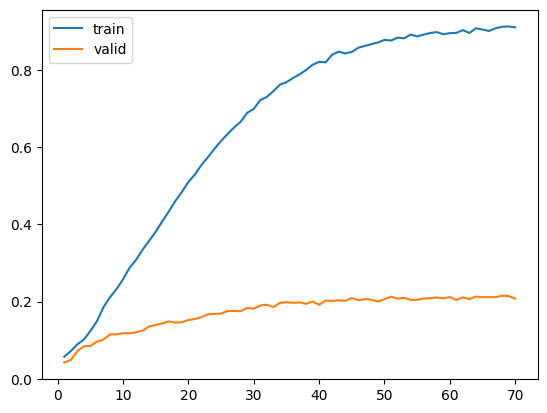

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Generación de secuencias nuevas

In [37]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [38]:
input_text='I\'m so in love with'

generate_seq(model, tok, input_text, max_length=5, n_words=2)

1/1 [==============================] - 0s 29ms/step


"I'm so in love with  "

### 6 - Beam search y muestreo aleatorio

In [41]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=5):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [42]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [43]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="Whether times are good")

1/1 [==============================] - 0s 20ms/step


In [44]:
# veamos las salidas
decode(salidas[0])

['whether times are good thank that our to little for']

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

Cambios que realice para mejorar el desempeño:
- Cambio en el dataset: Intente usar todas las canciones del dataset pero no pude correrlo en colab por el uso de la memoria, tambien intente usar los libros de "Lord of the Ring" pero tammbien el consumo de memoria ram supero el maximo en el mometo del entrenamiento. Encontre que con el artista 'al-green.txt' que el resultado de acuracy en la validacion fue un poco mejor pero todavia es baja y hay overfitting.
- Aumentar el train_len de 4 a 6
- Agregar bidireccionalidad
- Utilizar capaz GRU en lugar de LSTM
- Aumentar la cantidad de neuronas de 64 a 128

Luego de entrenar el modelo agregando mas neuronas pude lograr una mejora en accuracy. Tambien probe agregando capaz pero no mejoro.

A Difirencia del ejemplo visto en clase el acurracy en este caso fue de 20% peor todavia hay overfitting. Seria interesante ver que pasa con la totalidad de las camciones pero no lo puede entrenar.

Tambien intente usar mas cantidad de artistas pero el accuracy nunca supero el 10%